In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, ConfusionMatrixDisplay
)
from sklearn.preprocessing import StandardScaler

import lightgbm as lgb
from lightgbm import plot_tree

from sklearn.model_selection import StratifiedKFold
from bayes_opt import BayesianOptimization
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from scipy.stats import uniform, randint
RANDOM_STATE = 42

In [43]:
df = pd.read_csv('encoded_categorical_features.csv')

In [44]:
df.shape

(2927, 117)

In [45]:
df.dtypes.value_counts()

int64      62
bool       38
float64    17
Name: count, dtype: int64

We will be working with the version of the df where all missing values where handled and all categorical features where converted to numerical ones.

In [46]:
df['SalePrice_binned'] = pd.qcut(df['SalePrice'], q=5, labels=False)
df['SalePrice_binned'].value_counts()

SalePrice_binned
0    595
3    593
2    581
1    580
4    578
Name: count, dtype: int64

The continous SalesPrice target variable was discretisised into 5 classes.

In [47]:
X = df.drop(columns=['SalePrice', 'SalePrice_binned'])
Y = df['SalePrice_binned']

In [48]:
X.shape, Y.shape

((2927, 116), (2927,))

First, no stratification

In [49]:
'''80-20 unstratified k-fold cross validation with lightgbm classifier'''
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=RANDOM_STATE
)

In [50]:
lgb80_20 = lgb.LGBMClassifier(
    n_estimators=3,           # Number of boosting iterations - good default to start
    learning_rate=0.1,          # Controls how much we adjust weights - 0.1 is a good default
    max_depth=3,               # No limit on tree depth for better accuracy
    num_leaves=31,              # Maximum number of leaves in one tree
    min_child_samples=20,       # Minimum samples per leaf to prevent overfitting
    colsample_bytree=0.8,       # Fraction of features used per tree - helps prevent overfitting
    subsample=0.8,              # Fraction of samples used for training each tree
    random_state=RANDOM_STATE
)

In [51]:
lgb80_20.fit(X_train, y_train)

LGBMClassifier(colsample_bytree=0.8, max_depth=3, n_estimators=3,
               random_state=42, subsample=0.8)

In [52]:
y_pred80_20 = lgb80_20.predict(X_test)
y_pred80_20_proba = lgb80_20.predict_proba(X_test)
y_pred80_20
y_pred80_20_proba

array([[0.13725017, 0.13270014, 0.13740723, 0.18119891, 0.41144354],
       [0.21690384, 0.27812194, 0.19169431, 0.15693213, 0.15634777],
       [0.15321248, 0.14813328, 0.24759137, 0.29824207, 0.1528208 ],
       ...,
       [0.14253981, 0.13781442, 0.14270292, 0.14964222, 0.42730062],
       [0.16203821, 0.15666642, 0.19767879, 0.27259133, 0.21102526],
       [0.24759525, 0.25465319, 0.21090715, 0.14368974, 0.14315468]],
      shape=(586, 5))

In [53]:
acc = accuracy_score(y_test, y_pred80_20)
print(f'Accuracy: {acc:.4f}')

print('Classification Report:\n', classification_report(y_test, y_pred80_20))

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred80_20))


Accuracy: 0.6775
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.74      0.75       120
           1       0.51      0.61      0.56       121
           2       0.52      0.38      0.44       114
           3       0.70      0.76      0.73       120
           4       0.88      0.90      0.89       111

    accuracy                           0.68       586
   macro avg       0.68      0.68      0.67       586
weighted avg       0.67      0.68      0.67       586


Confusion Matrix:
 [[ 89  27   3   0   1]
 [ 22  74  21   3   1]
 [  4  40  43  27   0]
 [  1   3  14  91  11]
 [  0   0   2   9 100]]


<Figure size 8000x4000 with 0 Axes>

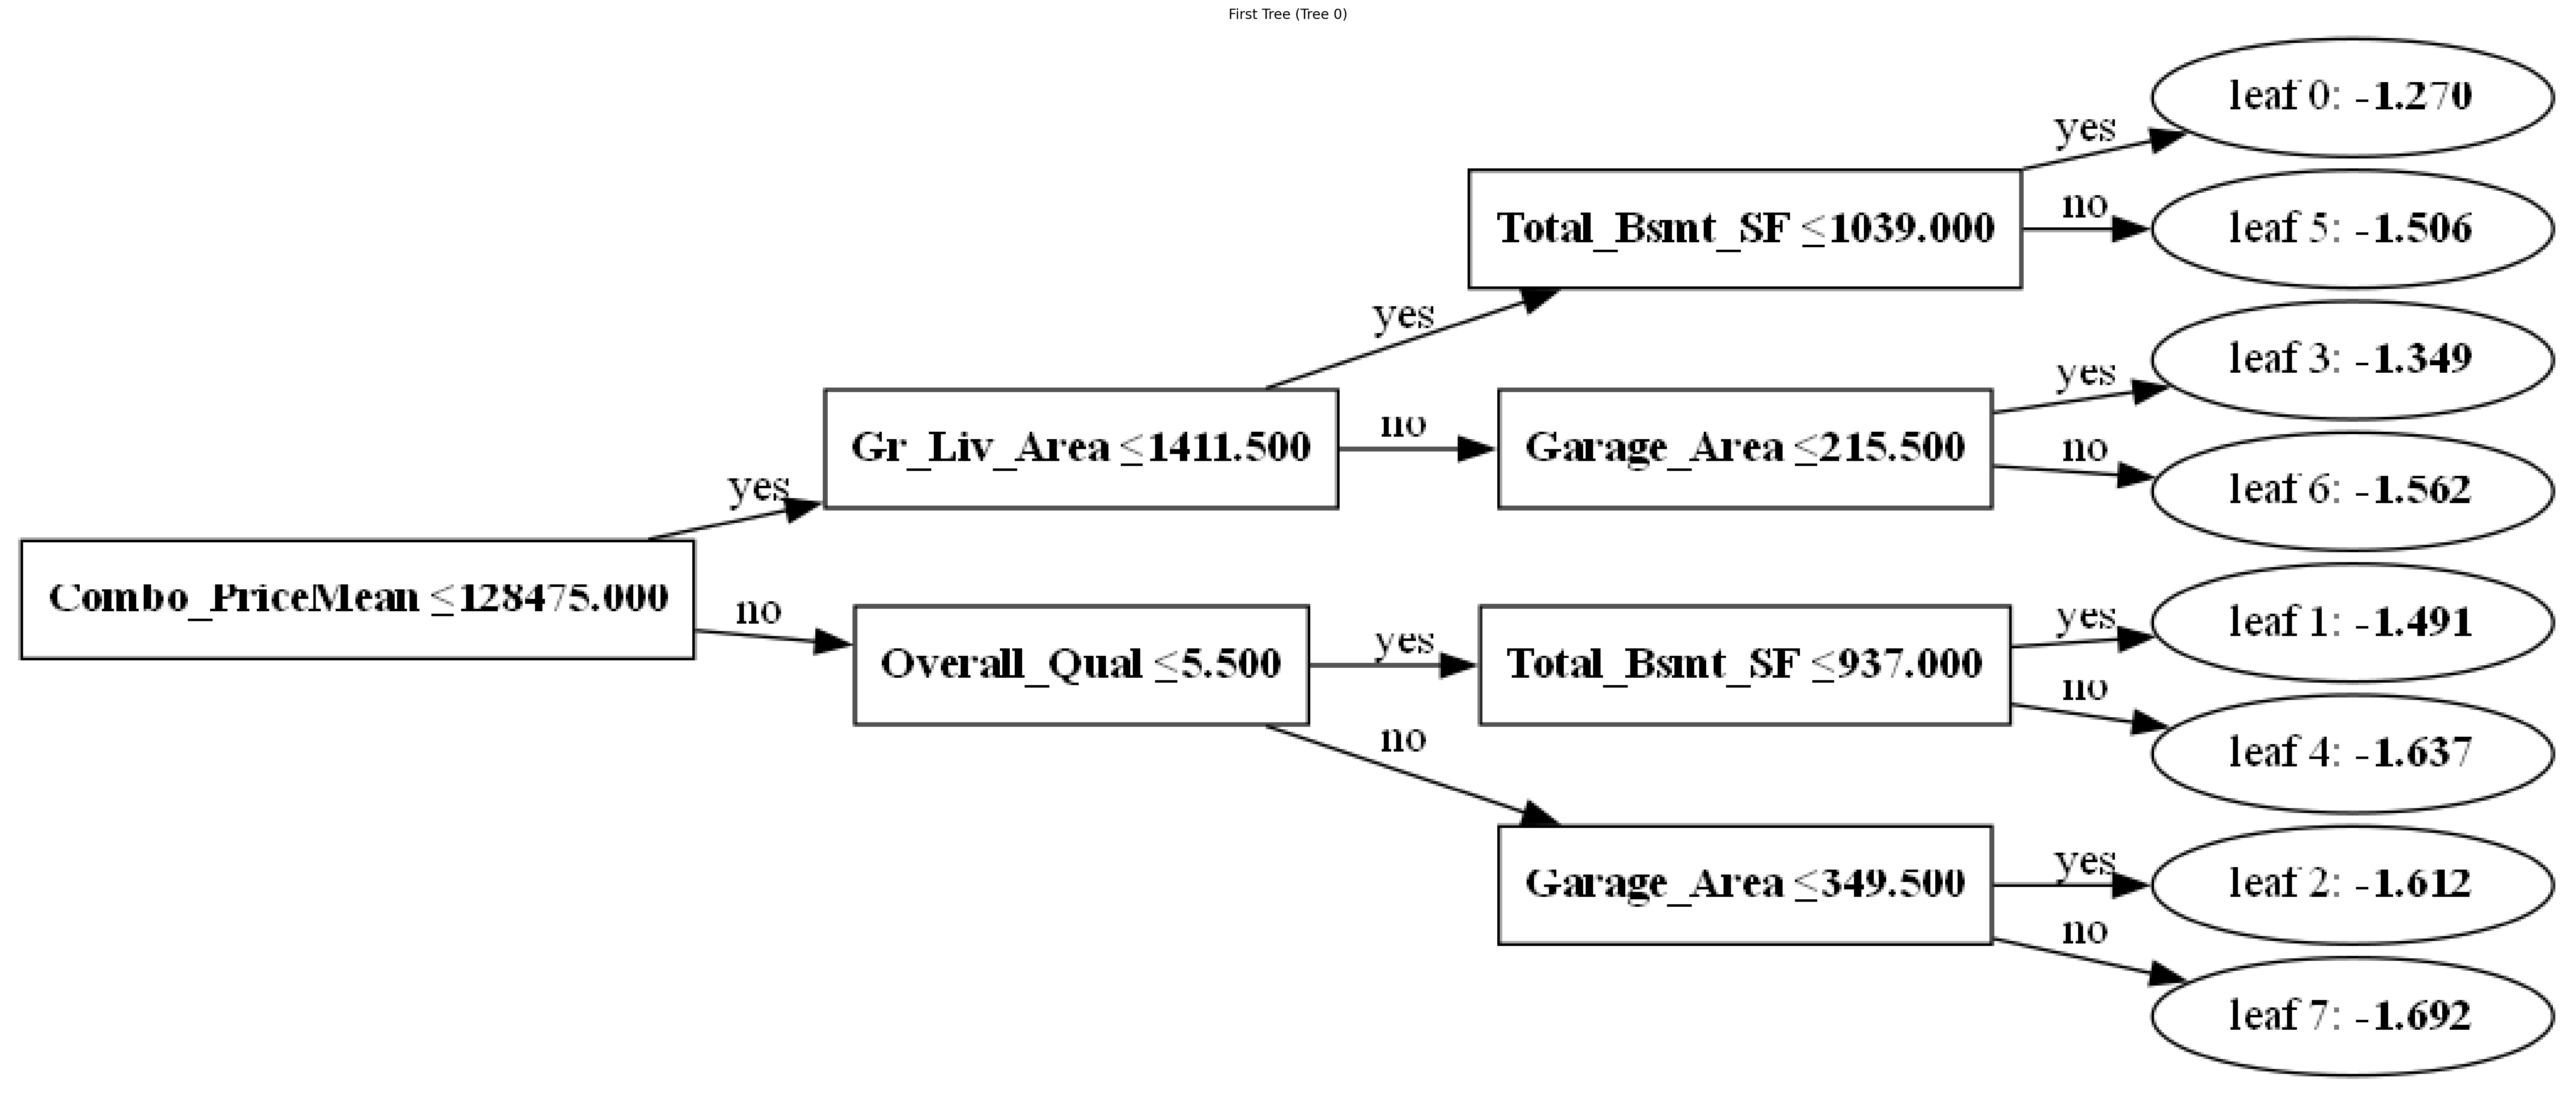

In [54]:
'''Plot of the first and last tree'''
# first tree = index 0
plt.figure(figsize=(40, 20), dpi=200)
plot_tree(lgb80_20, tree_index=0, figsize=(40, 20), dpi=200)
plt.title("First Tree (Tree 0)")
plt.show()


<Figure size 2000x1000 with 0 Axes>

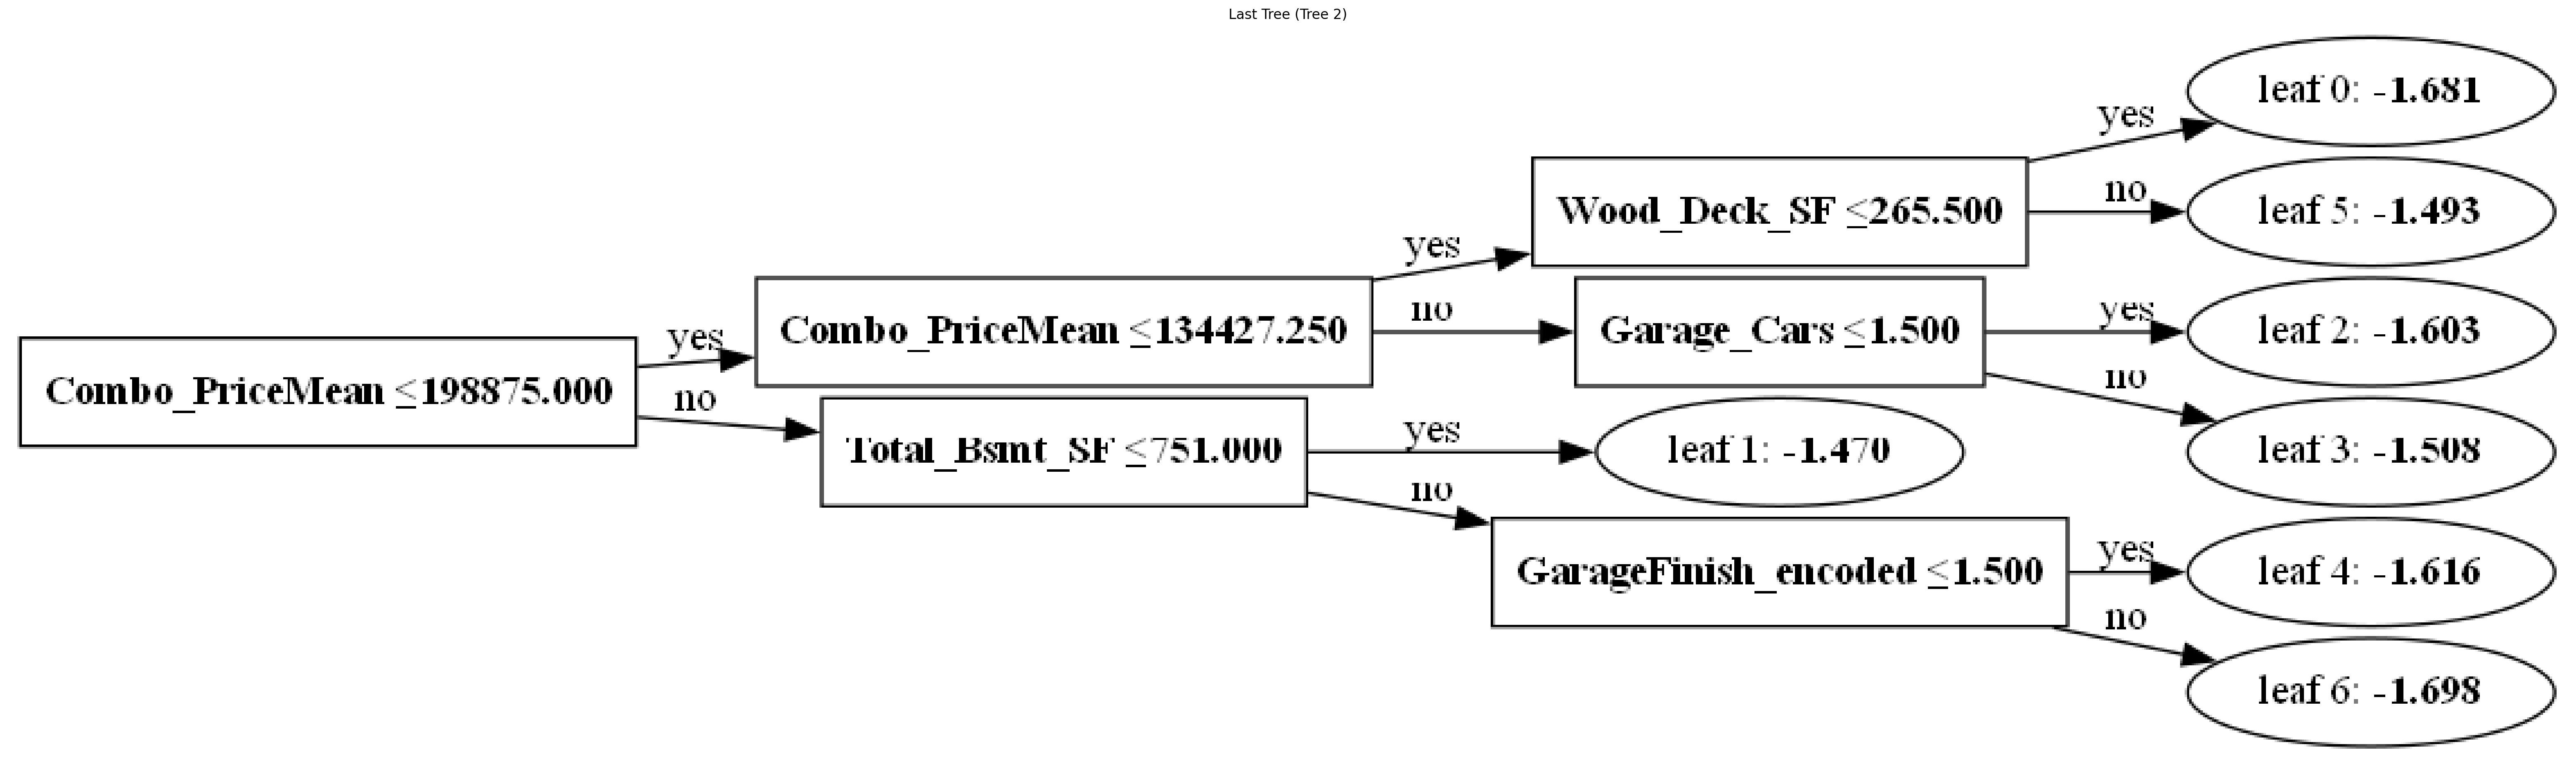

In [55]:
# last tree = index num_estimators - 1
last_tree_idx = lgb80_20.n_estimators - 1
plt.figure(figsize=(20, 10))
plot_tree(lgb80_20, tree_index=last_tree_idx, figsize=(40, 20), dpi=200)
plt.title(f"Last Tree (Tree {last_tree_idx})")
plt.show()

And now the same for 10-90 split.

In [56]:
'''90-10 unstratified k-fold cross validation with lightgbm classifier'''
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.1, random_state=RANDOM_STATE
)

In [57]:
lgb90_10 = lgb.LGBMClassifier(
    n_estimators=3,           # Number of boosting iterations - good default to start
    learning_rate=0.1,          # Controls how much we adjust weights - 0.1 is a good default
    max_depth=3,               # No limit on tree depth for better accuracy
    num_leaves=31,              # Maximum number of leaves in one tree
    min_child_samples=20,       # Minimum samples per leaf to prevent overfitting
    colsample_bytree=0.8,       # Fraction of features used per tree - helps prevent overfitting
    subsample=0.8,              # Fraction of samples used for training each tree
    random_state=RANDOM_STATE
)

In [58]:
lgb90_10.fit(X_train, y_train)

LGBMClassifier(colsample_bytree=0.8, max_depth=3, n_estimators=3,
               random_state=42, subsample=0.8)

In [59]:
y_pred90_10 = lgb90_10.predict(X_test)
y_pred90_10_proba = lgb90_10.predict_proba(X_test)  
y_pred90_10
y_pred90_10_proba

array([[0.13916042, 0.13210328, 0.13771495, 0.18170522, 0.40931613],
       [0.24823787, 0.27797472, 0.16426137, 0.15492651, 0.15459952],
       [0.15398986, 0.14618069, 0.25341921, 0.29481362, 0.15159661],
       ...,
       [0.14185088, 0.1346573 , 0.14037746, 0.2113545 , 0.37175986],
       [0.15398986, 0.14618069, 0.25341921, 0.29481362, 0.15159661],
       [0.29290222, 0.23671078, 0.18466521, 0.14301182, 0.14270997]],
      shape=(293, 5))

In [60]:
acc = accuracy_score(y_test, y_pred90_10)
print(f'Accuracy: {acc:.4f}')

print('Classification Report:\n', classification_report(y_test, y_pred90_10))

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred90_10))


Accuracy: 0.6724
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.85      0.76        54
           1       0.60      0.55      0.57        66
           2       0.45      0.37      0.41        54
           3       0.69      0.77      0.73        64
           4       0.90      0.84      0.87        55

    accuracy                           0.67       293
   macro avg       0.67      0.67      0.67       293
weighted avg       0.67      0.67      0.67       293


Confusion Matrix:
 [[46  7  1  0  0]
 [15 36 14  1  0]
 [ 6 15 20 13  0]
 [ 0  2  8 49  5]
 [ 0  0  1  8 46]]


<Figure size 8000x4000 with 0 Axes>

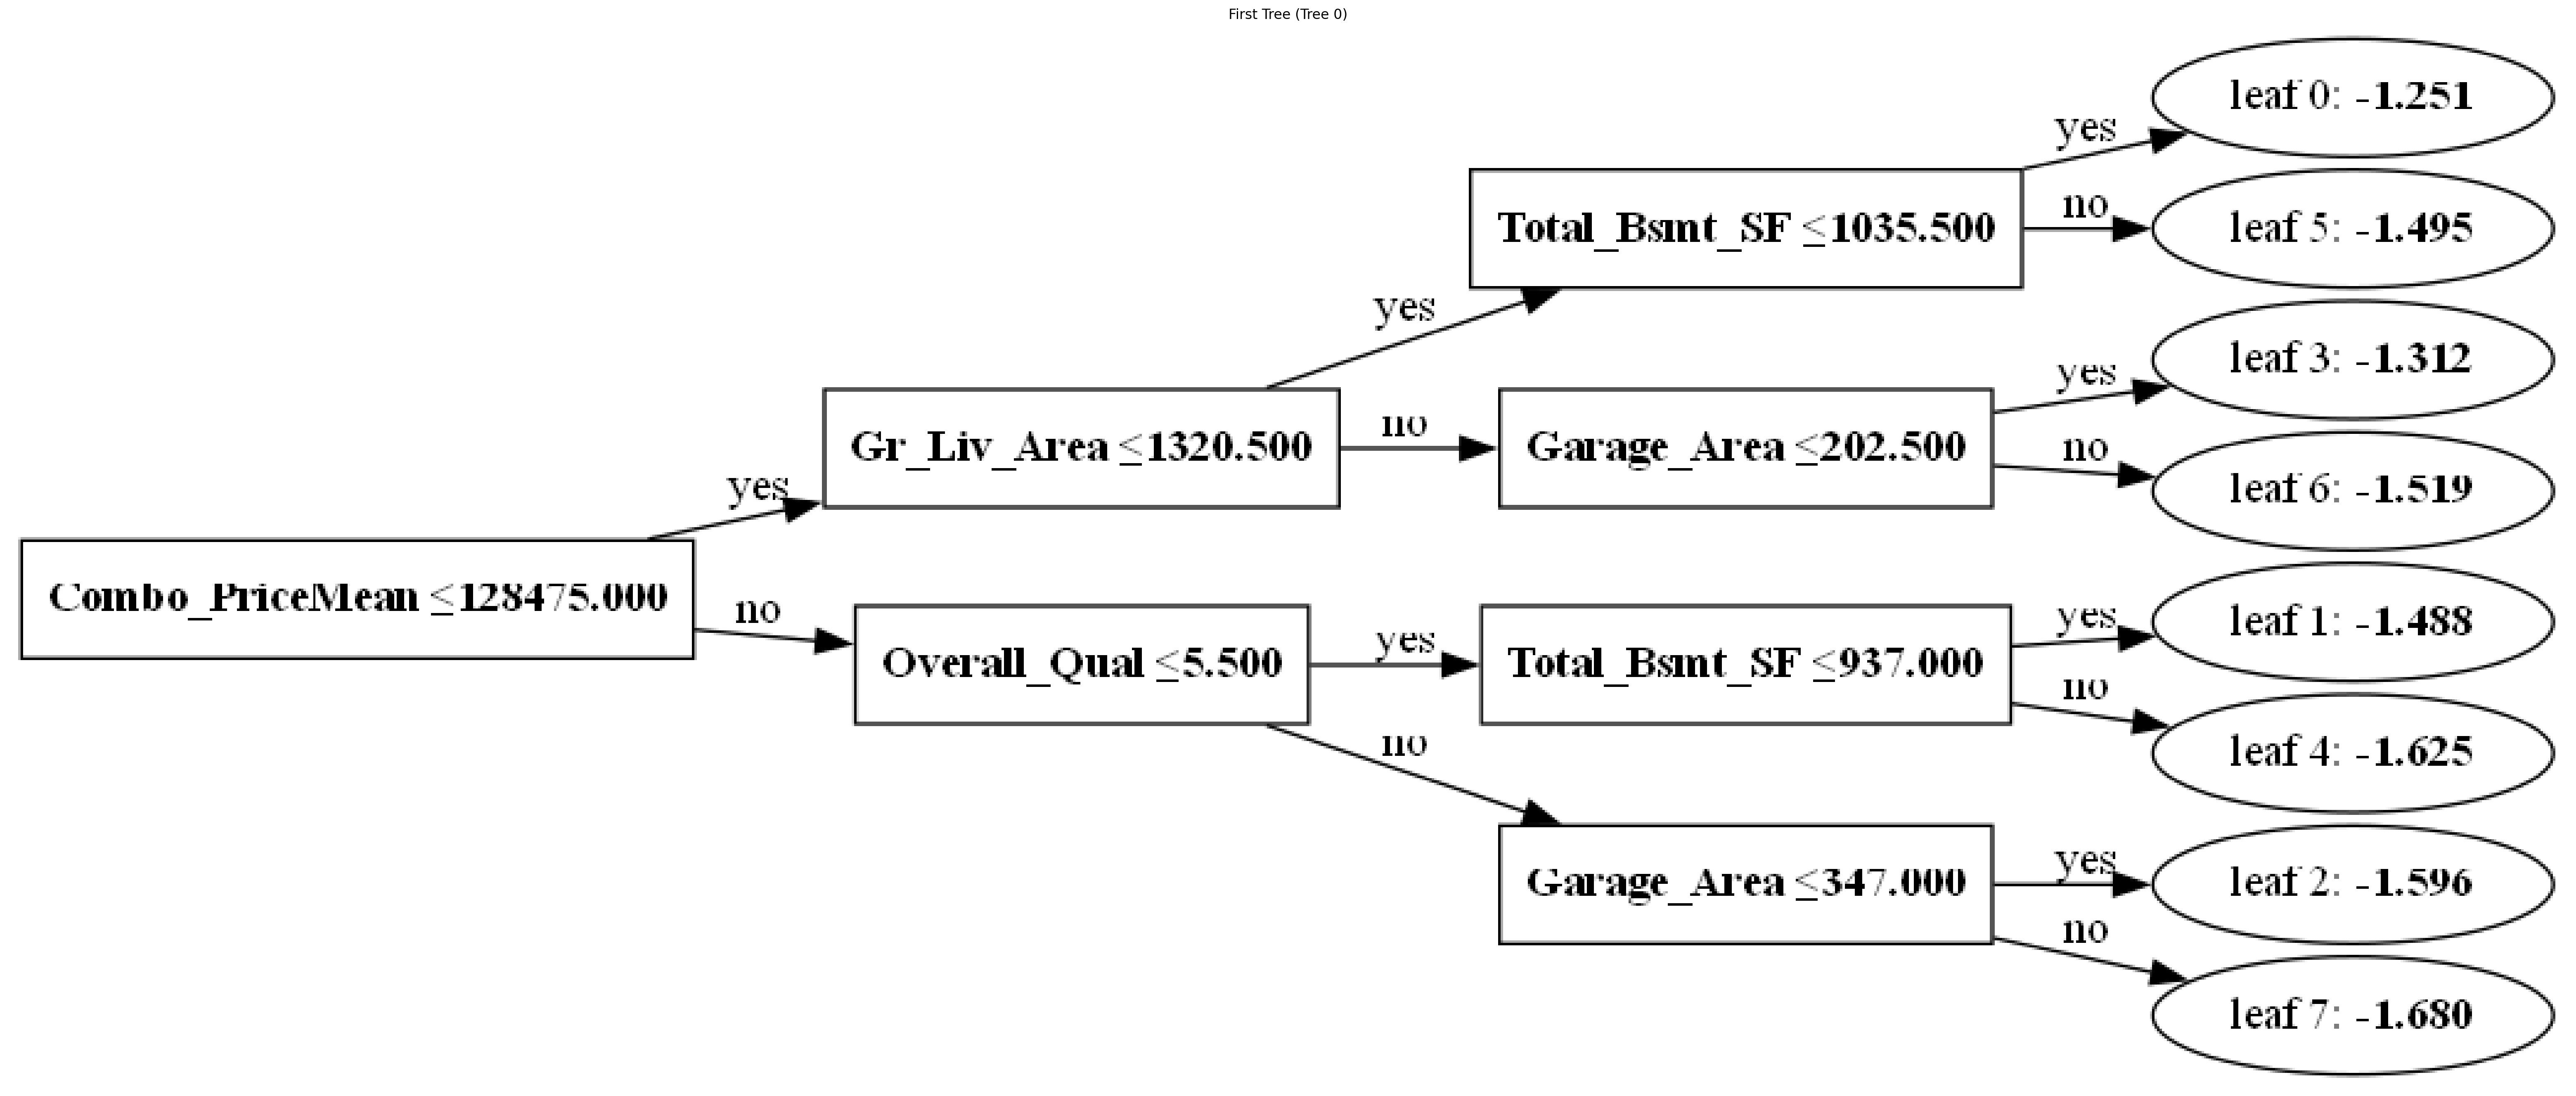

In [61]:
'''Plot of the first and last tree'''
# first tree = index 0
plt.figure(figsize=(40, 20), dpi=200)
plot_tree(lgb90_10, tree_index=0, figsize=(40, 20), dpi=200)
plt.title("First Tree (Tree 0)")
plt.show()


<Figure size 2000x1000 with 0 Axes>

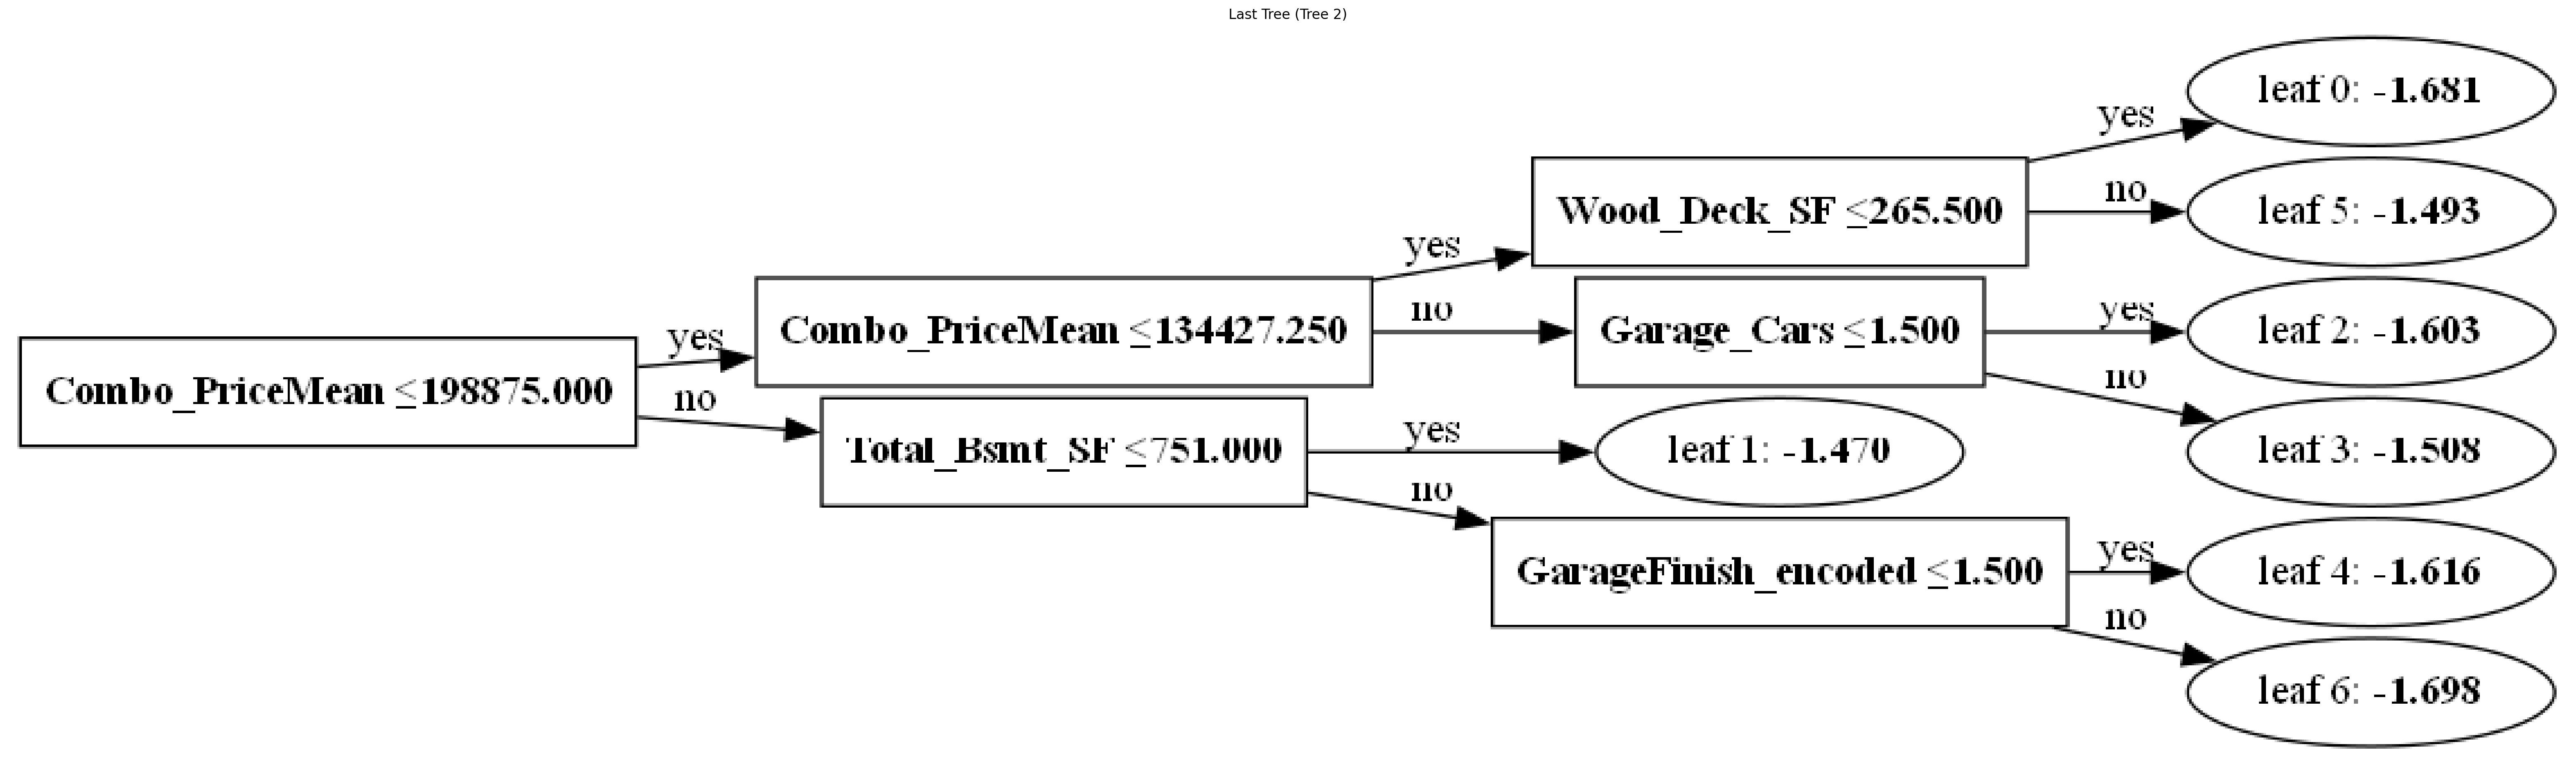

In [62]:
last_tree_idx = lgb90_10.n_estimators - 1
plt.figure(figsize=(20, 10))
plot_tree(lgb80_20, tree_index=last_tree_idx, figsize=(40, 20), dpi=200)
plt.title(f"Last Tree (Tree {last_tree_idx})")
plt.show()


Now using stratified k-fold and hyperparameter tuning.First with a 80-20 split.

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=RANDOM_STATE, stratify=Y)

In [64]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [65]:
lgb80_20_strat = lgb.LGBMClassifier(objective='multiclass',
                    num_class=5,
                    class_weight='balanced',
                    random_state=RANDOM_STATE,
                    verbose=-1
)

In [66]:
parameters = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 4, 5, 6, 7, 0],
    'learning_rate': [00.5, 0.1, 0.2, 0.5],
    'num_leaves': [20, 31, 40, 50],
    'min_child_samples': [10, 20, 30, 40],
    'subsample': [0.8, 1.0], # fraction of the training samples (rows) used to grow each tree
    'colsample_bytree': [0.8, 1.0] # fraction of features (columns) used when building each tree
}

Now for the parameter tuning: grid search

In [67]:
'''DO NOT RUN, TAKES TOO LONG'''

# grid_search = GridSearchCV(
#     estimator=xgb,
#     param_grid=parameters,
#     cv=skf,
#     scoring='accuracy'
# )

# grid_search.fit(X_train, y_train)

# print("Best Parameters:", grid_search.best_params_)
# print(f"Best Mean CV Accuracy: {grid_search.best_score_:.4f}")

'DO NOT RUN, TAKES TOO LONG'

Random Search

In [68]:
param_dict = {
    'max_depth': randint(3, 16),          # integer between 3 and 15
    'learning_rate': uniform(0.01, 0.49),  # float between 0.01 and 0.50
    'n_estimators': randint(50, 301),     # integer between 50 and 300
    'subsample': uniform(0.6, 0.4),       # float between 0.6 and 1.0
    'colsample_bytree': uniform(0.6, 0.4)
}

In [69]:
random_search = RandomizedSearchCV(
    lgb80_20_strat,
    param_dict,
    cv=skf,
    scoring='accuracy',
    n_iter=10
)


In [70]:
random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)

Best Parameters: {'colsample_bytree': np.float64(0.683787752879596), 'learning_rate': np.float64(0.07915385661814195), 'max_depth': 13, 'n_estimators': 123, 'subsample': np.float64(0.8615455135255514)}


In [71]:
best_model_80_20 = random_search.best_estimator_
y_pred = best_model_80_20.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)

In [72]:
print(f"Final Test Accuracy: {test_accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Final Test Accuracy: 0.7560

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.80      0.81       119
           1       0.60      0.66      0.63       116
           2       0.70      0.65      0.67       116
           3       0.76      0.83      0.79       119
           4       0.92      0.84      0.88       116

    accuracy                           0.76       586
   macro avg       0.76      0.76      0.76       586
weighted avg       0.76      0.76      0.76       586



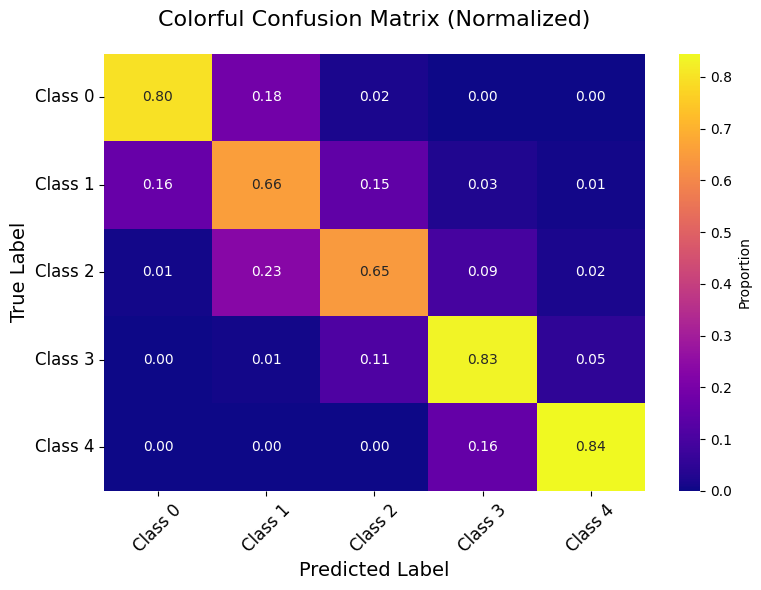

In [73]:
cm = confusion_matrix(y_test, y_pred, normalize='true')
labels = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f',
            cmap='plasma',
            xticklabels=labels, yticklabels=labels,
            cbar_kws={'label': 'Proportion'})
plt.title("Colorful Confusion Matrix (Normalized)", fontsize=16, pad=20)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12, rotation=0)
plt.tight_layout()
plt.show()


<Figure size 8000x4000 with 0 Axes>

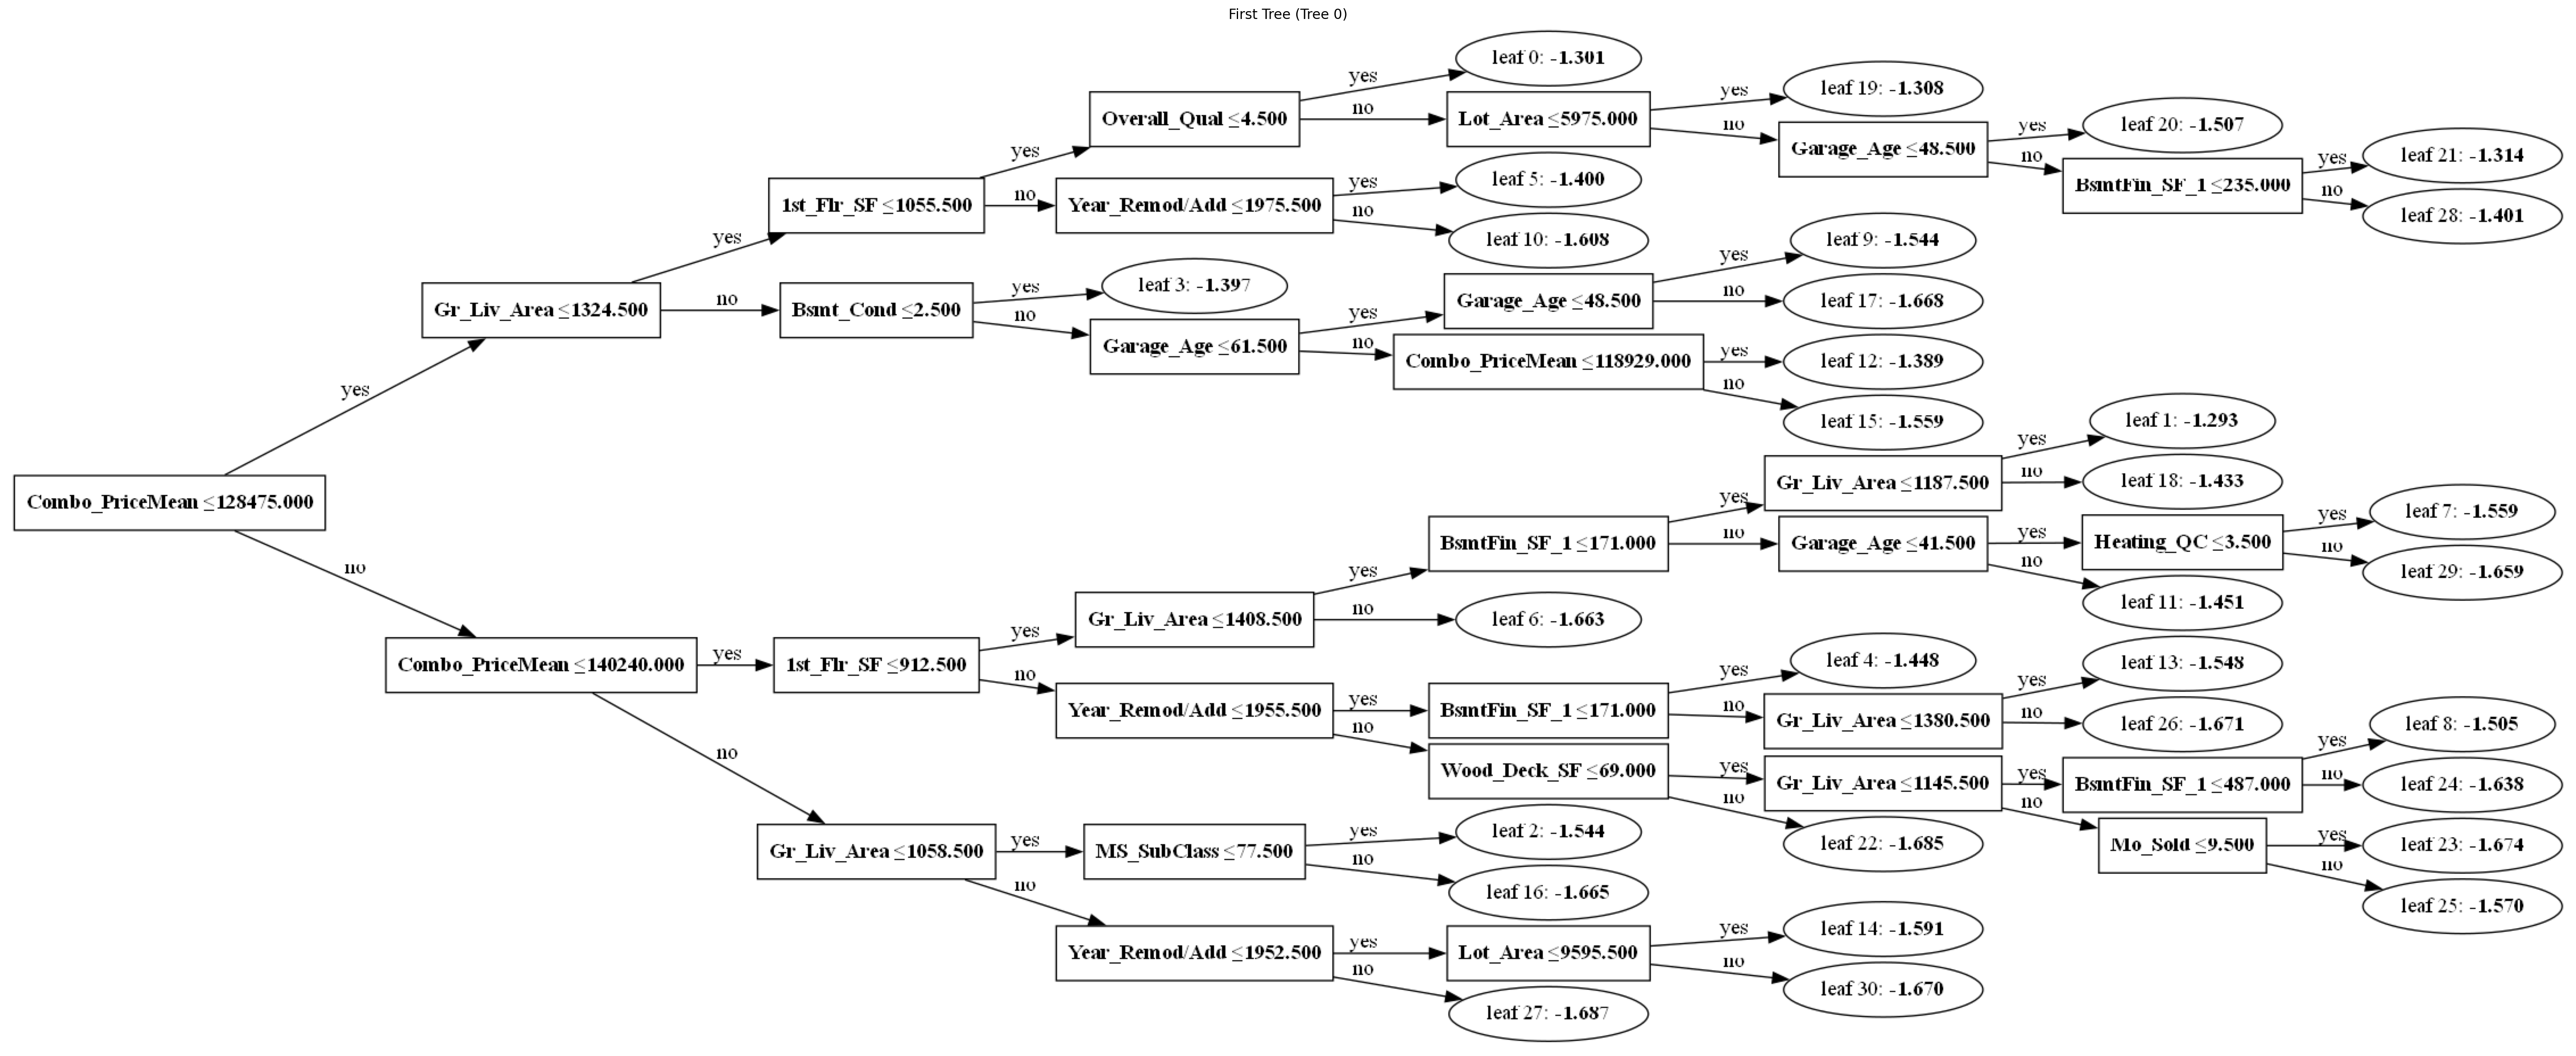

In [74]:
'''Plot of the first and last tree'''
# first tree = index 0
plt.figure(figsize=(40, 20), dpi=200)
plot_tree(best_model_80_20, tree_index=0, figsize=(40, 20), dpi=200)
plt.title("First Tree (Tree 0)")
plt.show()


<Figure size 2000x1000 with 0 Axes>

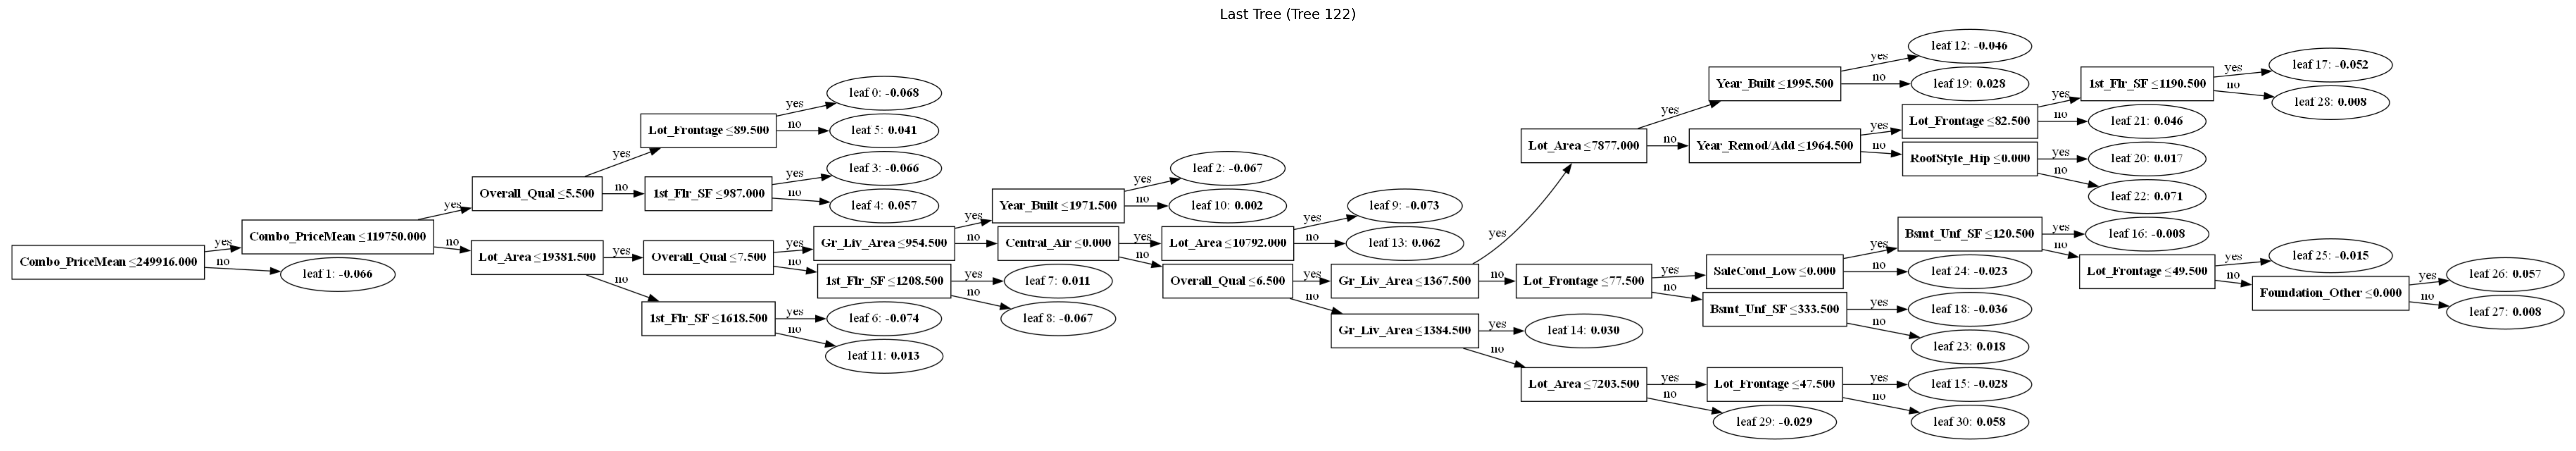

In [82]:
last_tree_idx = best_model_80_20.n_estimators - 1
plt.figure(figsize=(20, 10))
plot_tree(best_model_80_20, tree_index=last_tree_idx, figsize=(40, 20), dpi=200)
plt.title(f"Last Tree (Tree {last_tree_idx})")
plt.show()

Bayesian Optimisation

In [97]:
def black_box_function(n_estimators, max_depth, learning_rate, subsample, colsample_bytree):
    lgb_80_20_bayes = lgb.LGBMClassifier(
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        objective='multiclass',
        num_class=5
    )
    cv_scores = cross_val_score(lgb_80_20_bayes, X_train, y_train, cv=skf, scoring='accuracy')
    return cv_scores.mean()


In [99]:
'''Set the range for each hyperparameter'''
bounds = {
    'n_estimators': (50, 301),
    'max_depth': (3, 16),
    'learning_rate': (0.01, 0.50),
    'subsample': (0.6, 1.0),
    'colsample_bytree': (0.6, 1.0)
}

optimizer = BayesianOptimization(
    f=black_box_function,
    pbounds=bounds,
    random_state=RANDOM_STATE,

)

In [100]:
optimizer.maximize(init_points=5, n_iter=20)

'''
x = Hyperparameters
f(x) = model’s performance metric, as returned by your evaluation function
      (for example: accuracy, F1, cross-validated score, etc.)
'''
print("Best result: {}; f(x) = {}.".format(optimizer.max["params"], optimizer.max["target"]))


|   iter    |  target   | n_esti... | max_depth | learni... | subsample | colsam... |
-------------------------------------------------------------------------------------
| 1         | 0.7236231 | 144.00956 | 15.359285 | 0.3686770 | 0.8394633 | 0.6624074 |
| 2         | 0.7171577 | 89.154624 | 3.7550869 | 0.4344263 | 0.8404460 | 0.8832290 |
| 3         | 0.7175639 | 55.166708 | 15.608828 | 0.4178968 | 0.6849356 | 0.6727299 |
| 4         | 0.7289376 | 96.034531 | 6.9551491 | 0.2671306 | 0.7727780 | 0.7164916 |
| 5         | 0.7175639 | 203.57507 | 4.8134201 | 0.1531508 | 0.7465447 | 0.7824279 |
| 6         | 0.7240220 | 202.49375 | 3.0694088 | 0.3948680 | 0.8526560 | 0.7802895 |
| 7         | 0.7198237 | 149.24306 | 10.679368 | 0.1496665 | 0.7838138 | 0.6809454 |
| 8         | 0.7198237 | 164.42332 | 12.970488 | 0.2643130 | 0.6484099 | 0.6313590 |
| 9         | 0.7221166 | 76.882495 | 9.8287992 | 0.0881756 | 0.9304372 | 0.8973722 |
| 10        | 0.7171750 | 288.20358 | 15.743398 | 0.30

In [101]:
# extract best params
best_params = optimizer.max['params']
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['max_depth'] = int(best_params['max_depth'])

best_model = lgb.LGBMClassifier(
    **best_params,
    num_class=5,
    objective='multiclass'
)
best_model.fit(X_train, y_train)



LGBMClassifier(colsample_bytree=np.float64(0.7792008422262738),
               learning_rate=np.float64(0.14381683733135572), max_depth=7,
               n_estimators=274, num_class=5, objective='multiclass',
               subsample=np.float64(0.6374228791165418))

In [102]:
y_pred = best_model.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Final Test Accuracy: 0.7645

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.83      0.83        60
           1       0.66      0.66      0.66        58
           2       0.73      0.64      0.68        58
           3       0.72      0.83      0.77        59
           4       0.89      0.86      0.88        58

    accuracy                           0.76       293
   macro avg       0.77      0.76      0.76       293
weighted avg       0.77      0.76      0.76       293



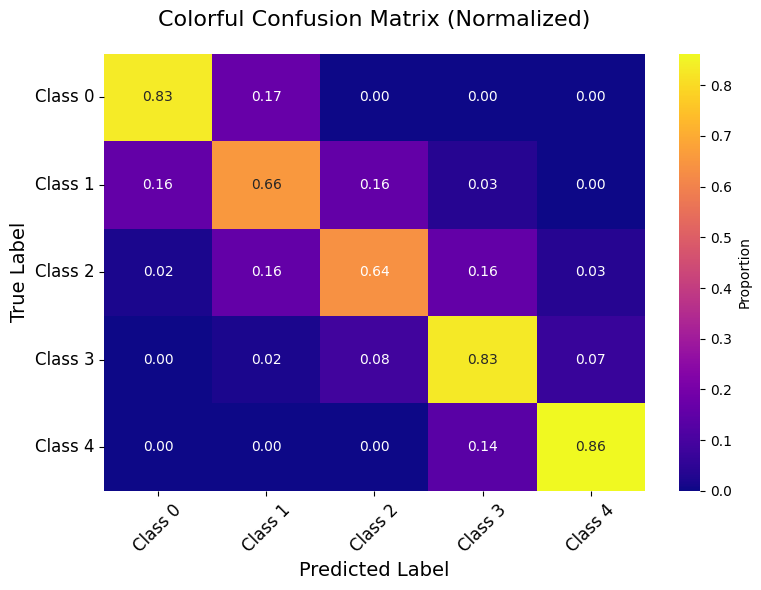

In [103]:
cm = confusion_matrix(y_test, y_pred, normalize='true')
labels = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f',
            cmap='plasma',
            xticklabels=labels, yticklabels=labels,
            cbar_kws={'label': 'Proportion'})
plt.title("Colorful Confusion Matrix (Normalized)", fontsize=16, pad=20)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12, rotation=0)
plt.tight_layout()
plt.show()


Now the 90-10 split with stratification and hyperparameter tuning.

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=RANDOM_STATE, stratify=Y)

In [77]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

In [88]:
lgb_90_10_strat = lgb.LGBMClassifier(objective='multiclass',
                    num_class=5,
                    class_weight='balanced',
                    random_state=RANDOM_STATE,
                    verbose=-1
)

In [83]:
parameters = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 4, 5, 6, 7, 0],
    'learning_rate': [00.5, 0.1, 0.2, 0.5],
    'num_leaves': [20, 31, 40, 50],
    'min_child_samples': [10, 20, 30, 40],
    'subsample': [0.8, 1.0], # fraction of the training samples (rows) used to grow each tree
    'colsample_bytree': [0.8, 1.0] # fraction of features (columns) used when building each tree
}

Grid Search

In [84]:
'''DO NOT RUN, TAKES TOO LONG'''

# grid_search = GridSearchCV(
#     estimator=xgb,
#     param_grid=parameters,
#     cv=skf,
#     scoring='accuracy'
# )

# grid_search.fit(X_train, y_train)

# print("Best Parameters:", grid_search.best_params_)
# print(f"Best Mean CV Accuracy: {grid_search.best_score_:.4f}")

'DO NOT RUN, TAKES TOO LONG'

Random Search

In [85]:
param_dict = {
    'max_depth': randint(3, 16),          # integer between 3 and 15
    'learning_rate': uniform(0.01, 0.49),  # float between 0.01 and 0.50
    'n_estimators': randint(50, 301),     # integer between 50 and 300
    'subsample': uniform(0.6, 0.4),       # float between 0.6 and 1.0
    'colsample_bytree': uniform(0.6, 0.4)
}

In [90]:
random_search = RandomizedSearchCV(
    lgb_90_10_strat,
    param_dict,
    cv=skf,
    scoring='accuracy',
    n_iter=10
)


In [91]:
random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)

Best Parameters: {'colsample_bytree': np.float64(0.6724593767328437), 'learning_rate': np.float64(0.2083995696868696), 'max_depth': 12, 'n_estimators': 280, 'subsample': np.float64(0.8090040358645144)}


In [92]:
best_model_90_10 = random_search.best_estimator_
y_pred = best_model_90_10.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)

In [93]:
print(f"Final Test Accuracy: {test_accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Final Test Accuracy: 0.7474

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.82      0.82        60
           1       0.65      0.64      0.64        58
           2       0.68      0.62      0.65        58
           3       0.70      0.81      0.75        59
           4       0.89      0.84      0.87        58

    accuracy                           0.75       293
   macro avg       0.75      0.75      0.75       293
weighted avg       0.75      0.75      0.75       293



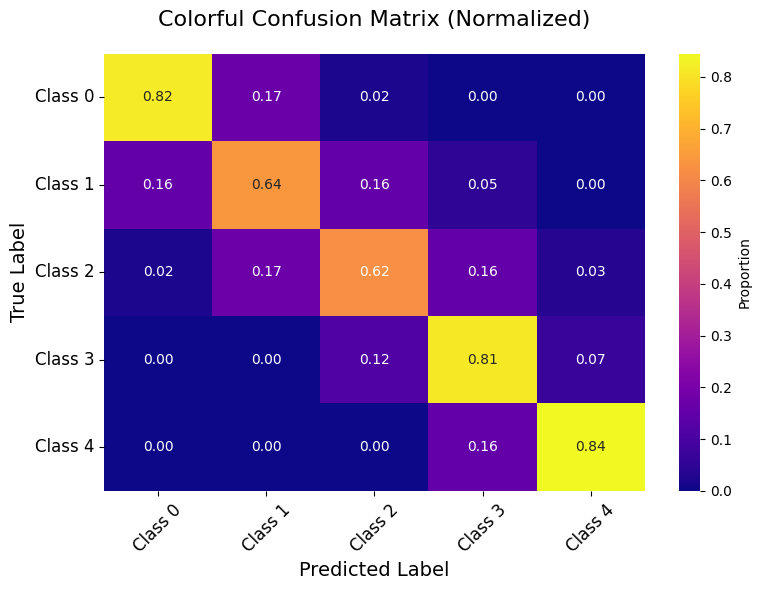

In [94]:
cm = confusion_matrix(y_test, y_pred, normalize='true')
labels = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f',
            cmap='plasma',
            xticklabels=labels, yticklabels=labels,
            cbar_kws={'label': 'Proportion'})
plt.title("Colorful Confusion Matrix (Normalized)", fontsize=16, pad=20)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12, rotation=0)
plt.tight_layout()
plt.show()


<Figure size 8000x4000 with 0 Axes>

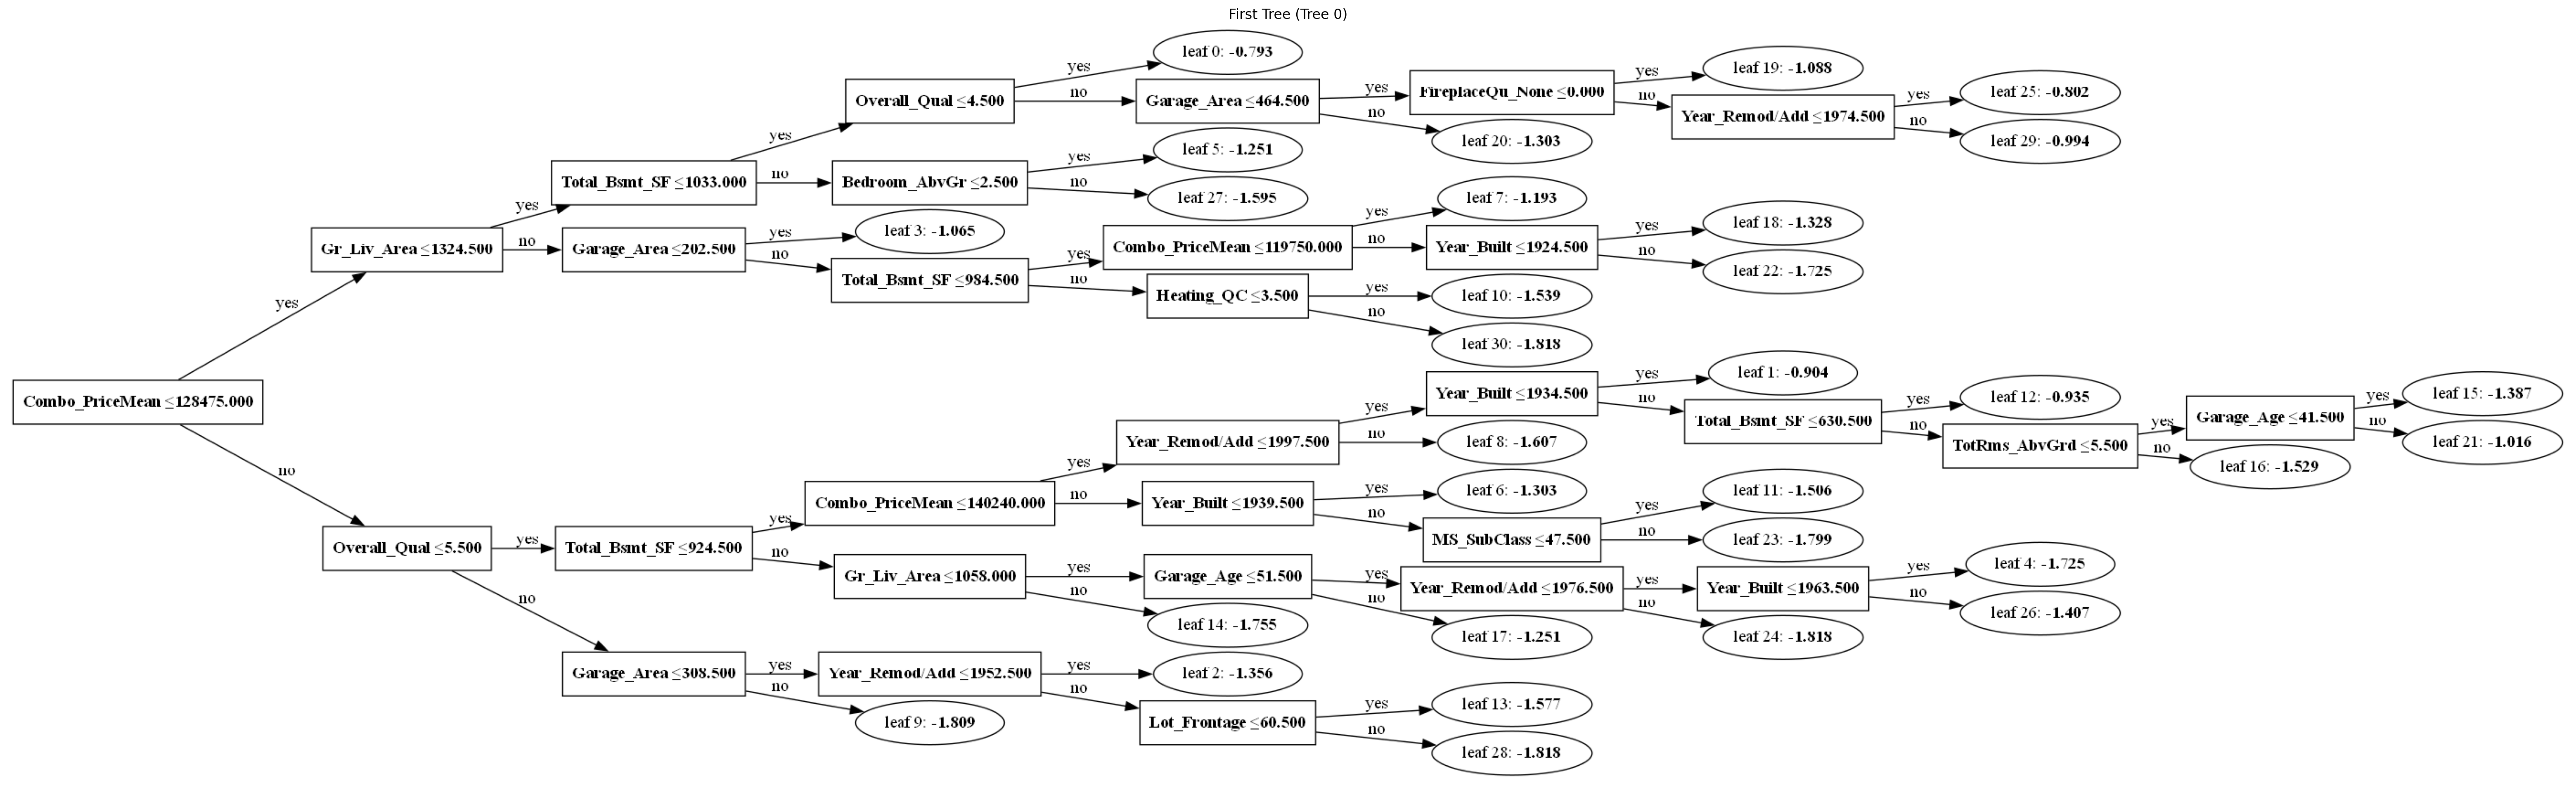

In [95]:
'''Plot of the first and last tree'''
# first tree = index 0
plt.figure(figsize=(40, 20), dpi=200)
plot_tree(best_model_90_10, tree_index=0, figsize=(40, 20), dpi=200)
plt.title("First Tree (Tree 0)")
plt.show()

<Figure size 2000x1000 with 0 Axes>

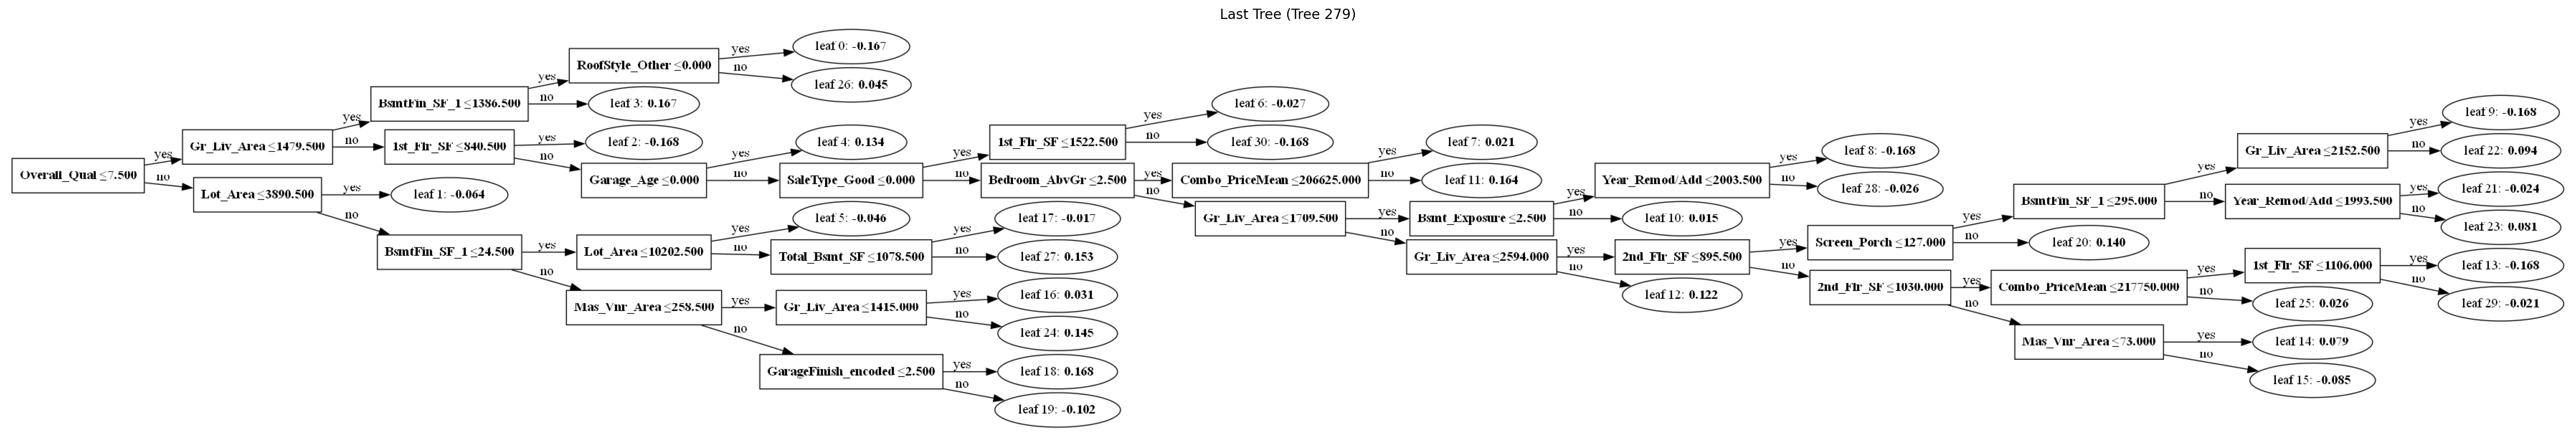

In [96]:
last_tree_idx = best_model_90_10.n_estimators - 1
plt.figure(figsize=(20, 10))
plot_tree(best_model_90_10, tree_index=last_tree_idx, figsize=(40, 20), dpi=200)
plt.title(f"Last Tree (Tree {last_tree_idx})")
plt.show()

Bayesian Optimisation

In [104]:
def black_box_function(n_estimators, max_depth, learning_rate, subsample, colsample_bytree):
    lgb_90_10_bayes = lgb.LGBMClassifier(
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        objective='multiclass',
        num_class=5
    )
    cv_scores = cross_val_score(lgb_90_10_bayes, X_train, y_train, cv=skf, scoring='accuracy')
    return cv_scores.mean()



In [105]:
'''Set the range for each hyperparameter'''
bounds = {
    'n_estimators': (50, 301),
    'max_depth': (3, 16),
    'learning_rate': (0.01, 0.50),
    'subsample': (0.6, 1.0),
    'colsample_bytree': (0.6, 1.0)
}

optimizer = BayesianOptimization(
    f=black_box_function,
    pbounds=bounds,
    random_state=42
)

In [106]:
optimizer.maximize(init_points=5, n_iter=20)

'''
x = Hyperparameters
f(x) = model’s performance metric, as returned by your evaluation function
      (for example: accuracy, F1, cross-validated score, etc.)
'''
print("Best result: {}; f(x) = {}.".format(optimizer.max["params"], optimizer.max["target"]))


|   iter    |  target   | n_esti... | max_depth | learni... | subsample | colsam... |
-------------------------------------------------------------------------------------
| 1         | 0.7236231 | 144.00956 | 15.359285 | 0.3686770 | 0.8394633 | 0.6624074 |
| 2         | 0.7171577 | 89.154624 | 3.7550869 | 0.4344263 | 0.8404460 | 0.8832290 |
| 3         | 0.7175639 | 55.166708 | 15.608828 | 0.4178968 | 0.6849356 | 0.6727299 |
| 4         | 0.7289376 | 96.034531 | 6.9551491 | 0.2671306 | 0.7727780 | 0.7164916 |
| 5         | 0.7175639 | 203.57507 | 4.8134201 | 0.1531508 | 0.7465447 | 0.7824279 |
| 6         | 0.7240220 | 202.49375 | 3.0694088 | 0.3948680 | 0.8526560 | 0.7802895 |
| 7         | 0.7198237 | 149.24306 | 10.679368 | 0.1496665 | 0.7838138 | 0.6809454 |
| 8         | 0.7198237 | 164.42332 | 12.970488 | 0.2643130 | 0.6484099 | 0.6313590 |
| 9         | 0.7221166 | 76.882495 | 9.8287992 | 0.0881756 | 0.9304372 | 0.8973722 |
| 10        | 0.7171750 | 288.20358 | 15.743398 | 0.30

In [108]:
# extract best params
best_params = optimizer.max['params']
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['max_depth'] = int(best_params['max_depth'])

best_model = lgb.LGBMClassifier(
    **best_params,
    num_class=5,
    objective='multiclass'
)
best_model.fit(X_train, y_train)



LGBMClassifier(colsample_bytree=np.float64(0.7792008422262738),
               learning_rate=np.float64(0.14381683733135572), max_depth=7,
               n_estimators=274, num_class=5, objective='multiclass',
               subsample=np.float64(0.6374228791165418))

In [109]:
y_pred = best_model.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))



Final Test Accuracy: 0.7645

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.83      0.83        60
           1       0.66      0.66      0.66        58
           2       0.73      0.64      0.68        58
           3       0.72      0.83      0.77        59
           4       0.89      0.86      0.88        58

    accuracy                           0.76       293
   macro avg       0.77      0.76      0.76       293
weighted avg       0.77      0.76      0.76       293



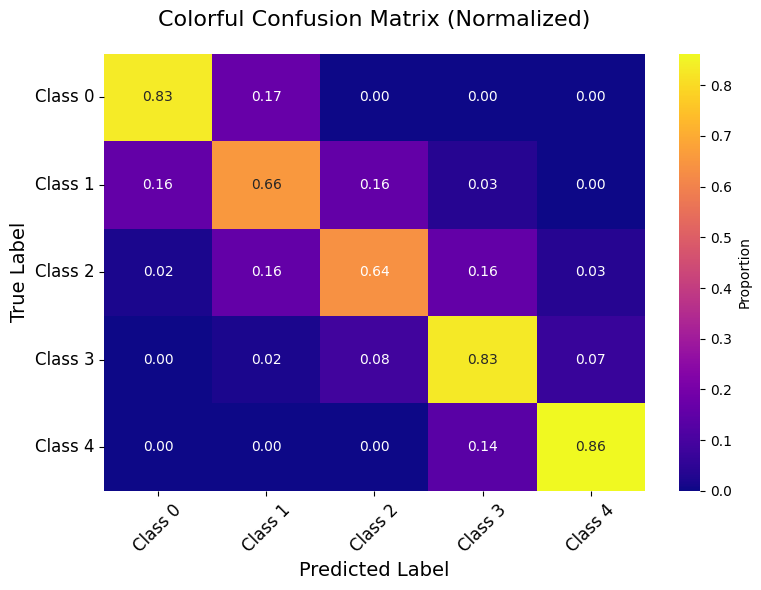

In [110]:
cm = confusion_matrix(y_test, y_pred, normalize='true')
labels = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f',
            cmap='plasma',
            xticklabels=labels, yticklabels=labels,
            cbar_kws={'label': 'Proportion'})
plt.title("Colorful Confusion Matrix (Normalized)", fontsize=16, pad=20)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12, rotation=0)
plt.tight_layout()
plt.show()
